In [1]:
%config IPCompleter.greedy=True
#from preproc.py import FullPipeline
%run preproc.ipynb
!jupyter kernelspec list
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
import sys
print('Python3 executable is ',sys.executable)


data = pd.read_csv("datasets/titanic/train.csv")

Available kernels:
  python3    /home/ssashita/anaconda3/share/jupyter/kernels/python3
Python3 executable is  /home/ssashita/anaconda3/envs/python3env/bin/python


In [51]:
data.describe()
full_pipel = FullPipeline()
data_prepared = full_pipel.full_pipeline_apply_features(data,non_num_attrs=["Sex","Ticket","Cabin","Embarked"], num_attrs=["Pclass","Age","SibSp","Parch","Fare"])
labels_prepared = full_pipel.full_pipeline_apply_labels(data,label_data_non_num=["Survived"])
print('data_prepared.shape',data_prepared.shape)
print("labels_prepared.shape",labels_prepared.shape)

data_train,data_test,label_train,label_test = train_test_split(data_prepared,labels_prepared,test_size=0.2,random_state=42)


numattrs is not None
Both num_pipeline and cat_pipeline exist
(4, 891) 4 4
xx shape is (891, 834)
data_prepared.shape (891, 839)
labels_prepared.shape (891, 1)


In [52]:
label_train = label_train.ravel()
label_test= label_test.ravel()

### Quickly Try Decision tree

In [53]:
dtree_classifier = DecisionTreeClassifier(random_state=42,max_depth=8)
dtree_classifier.fit(data_train,label_train)
dtree_classifier.score(data_test, label_test)

0.8268156424581006

### Then RandomForest

In [225]:
F= int(np.log2(data_prepared.shape[1])+1)
rndf_classifier = RandomForestClassifier(n_estimators=1000,max_features=F,random_state=42,oob_score=True, bootstrap=True, n_jobs=-1)
rndf_classifier.fit(data_train, label_train.ravel())
rndf_classifier.score(data_test, label_test.ravel())

0.8379888268156425

In [91]:
rndf_classifier.oob_score_

0.827247191011236

### Logistic Regression

In [178]:
from sklearn.linear_model import LogisticRegressionCV

logit_classifier=LogisticRegressionCV(Cs=[1.0],max_iter=2000,cv=5,random_state=42,n_jobs=-1,penalty='l2',solver='newton-cg')
logit_classifier.fit(data_train, label_train)
print('score on test data',logit_classifier.score(data_test, label_test))

score on test data 0.8324022346368715


### SVM classification using kernel trick

In [282]:
from sklearn.svm import SVC

svc_classifier=SVC(C=1000,degree=3,gamma='scale',kernel='poly',coef0=0.1,decision_function_shape='ovo')
svc_classifier.fit(data_train, label_train)
print(svc_classifier.score(data_test, label_test))

0.8379888268156425


### Ada Boost 

In [307]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import mean_squared_error

ada_best = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=7),learning_rate=0.70,n_estimators=150,random_state=49,algorithm="SAMME.R")
ada_best.fit(data_train,label_train)
ada_best.score(data_test,label_test)

0.8435754189944135

### Voting Classifier - The best so far

In [310]:
from sklearn.ensemble import VotingClassifier
logit_classifier=LogisticRegressionCV(Cs=[1.0],max_iter=2000,cv=5,random_state=42,n_jobs=-1,penalty='l2',solver='newton-cg')
rndf_classifier = RandomForestClassifier(n_estimators=2000, max_depth=7,max_features=F,random_state=42,bootstrap=True, n_jobs=-1)
ada_best = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=7),learning_rate=0.70,n_estimators=150,random_state=49,algorithm="SAMME.R")
svc_classifier=SVC(C=1000,degree=3,gamma='scale',kernel='poly',coef0=0.1,decision_function_shape='ovo',probability=True)

vote_classifier = VotingClassifier(estimators=[('ada',ada_best),('logist',logit_classifier),('svc', svc_classifier)], voting="soft")
vote_classifier.fit(data_train,label_train.ravel())
print(vote_classifier.score(data_test, label_test.ravel()))

#print(svc_classifier.fit(data_train,label_train).score(data_test, label_test.ravel()))

0.8435754189944135


In [323]:
testdata = pd.read_csv("datasets/titanic/test.csv")
testdata_prepared = full_pipel.full_features_pipeline_.transform(testdata)
testdata['Survived']=vote_classifier.predict(testdata_prepared)
testdata[['PassengerId','Survived']].to_csv(path_or_buf="datasets/titanic/results.csv",header=True,index=False)

xx shape is (418, 834)


In [324]:
vote_classifier.fit(data_prepared,labels_prepared.ravel())
print(vote_classifier.score(data_test, label_test.ravel()))

0.9888268156424581


In [325]:
testdata = pd.read_csv("datasets/titanic/test.csv")
testdata_prepared = full_pipel.full_features_pipeline_.transform(testdata)
testdata['Survived']=vote_classifier.predict(testdata_prepared)
testdata[['PassengerId','Survived']].to_csv(path_or_buf="datasets/titanic/results2.csv",header=True,index=False)

xx shape is (418, 834)


In [326]:
result1=pd.read_csv('datasets/titanic/results.csv',index_col='PassengerId')
result2=pd.read_csv('datasets/titanic/results2.csv',index_col='PassengerId')



In [331]:
mean_squared_error(result1,result2)

0.08373205741626795

In [374]:
#Use only ada boost
testdata = pd.read_csv("datasets/titanic/test.csv")
testdata_prepared = full_pipel.full_features_pipeline_.transform(testdata)
testdata['Survived']=ada_classifier.predict(testdata_prepared)
testdata[['PassengerId','Survived']].to_csv(path_or_buf="datasets/titanic/results4.csv",header=True,index=False)

xx shape is (418, 834)


In [378]:
result1=pd.read_csv('datasets/titanic/results.csv',index_col='PassengerId')
result2=pd.read_csv('datasets/titanic/results2.csv',index_col='PassengerId')
result3=pd.read_csv('datasets/titanic/results4.csv',index_col='PassengerId')

mean_squared_error(result2,result1)

0.08373205741626795

# Dimension reduction

 ### Using PCA

In [57]:
from sklearn.decomposition import PCA, KernelPCA, SparsePCA

pca=PCA(random_state=42, n_components=0.95)
X_reduced = pca.fit_transform(data_train.toarray())
X_test_reduced = pca.transform(data_test.toarray())

In [58]:
print("Columns reduced to ",X_reduced.shape[1])

Columns reduced to  315


### Random Forest with reduced data

In [60]:
F= int(np.log2(X_reduced.shape[1]))
rndf_classifier = RandomForestClassifier(n_estimators=2000, max_features=F,random_state=42,oob_score=True, bootstrap=True, n_jobs=-1)
rndf_classifier.fit(X_reduced, label_train.ravel())
rndf_classifier.score(X_test_reduced, label_test.ravel())

0.8212290502793296

### Lasso logistic regression

In [61]:
lasso_classifier=LogisticRegressionCV(Cs=[1.0],max_iter=2000,cv=5,random_state=42,n_jobs=-1,penalty='l1',solver='saga')
lasso_classifier.fit(X_reduced, label_train)
print('score on test data',lasso_classifier.score(X_test_reduced, label_test))

score on test data 0.8268156424581006


In [73]:
X_reduced_after_lasso = X_reduced[:,lasso_classifier.coef_[0]!=0.0]
X_test_reduced_after_lasso = X_test_reduced[:,lasso_classifier.coef_[0]!=0.0]
print("Columns further reduced to",X_reduced_after_lasso.shape[1])

Columns further reduced to 45


### Now Logistic with l2 penalty and reduced features - same answer for score as Lasso (l1)

In [177]:
logit_classifier=LogisticRegressionCV(Cs=[1.0],max_iter=2000,cv=5,random_state=42,n_jobs=-1,penalty='l2',solver='newton-cg')
logit_classifier.fit(X_reduced_after_lasso, label_train)
print('score on test data',logit_classifier.score(X_test_reduced_after_lasso, label_test))

score on test data 0.8268156424581006


### Random Forest with lasso reduced features

In [83]:
F= int(np.log2(X_reduced_after_lasso.shape[1]))
rndf_classifier = RandomForestClassifier(n_estimators=2000, max_depth=7,max_features=F,random_state=42,oob_score=True, bootstrap=True, n_jobs=-1)
rndf_classifier.fit(X_reduced_after_lasso, label_train.ravel())
rndf_classifier.score(X_test_reduced_after_lasso, label_test.ravel())
rndf_classifier.oob_score_

0.8146067415730337

### Attempt voting classifier for the X_reduced_after_lasso data
### This was my 3rd attempt uploading to Kaggle, but didnt improve over previous

In [361]:
from sklearn.svm import SVC

svc_classifier=SVC(C=1000,degree=4,gamma='scale',kernel='poly',coef0=0.1,decision_function_shape='ovo',probability=True)
svc_classifier.fit(X_reduced_after_lasso, label_train)
print(svc_classifier.score(X_test_reduced_after_lasso, label_test))

0.8212290502793296


In [358]:
ada_best = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),learning_rate=0.69,n_estimators=56,random_state=49,algorithm="SAMME.R")
ada_best.fit(X_reduced_after_lasso,label_train)
ada_best.score(X_test_reduced_after_lasso,label_test)

0.8268156424581006

In [371]:
#For the entire train.csv data
pca=PCA(random_state=42, n_components=0.95)
X_reduced = pca.fit_transform(data_prepared.toarray())
logit_classifier=LogisticRegressionCV(Cs=[1.0],max_iter=2000,cv=5,random_state=42,n_jobs=-1,penalty='l2',solver='newton-cg')
rndf_classifier = RandomForestClassifier(n_estimators=2000, max_depth=7,max_features=F,random_state=42,oob_score=True, bootstrap=True, n_jobs=-1)
svc_classifier=SVC(C=1000,degree=4,gamma='scale',kernel='poly',coef0=0.1,decision_function_shape='ovo',probability=True)
ada_best = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),learning_rate=0.69,n_estimators=56,random_state=49,algorithm="SAMME.R")

vote_classifier = VotingClassifier(estimators=[('ada',ada_best),('logist',logit_classifier),('svc', svc_classifier)], voting="soft")
vote_classifier.fit(X_reduced,labels_prepared.ravel())
print(vote_classifier.score(X_reduced, labels_prepared.ravel()))

0.9113355780022446


In [372]:
testdata = pd.read_csv("datasets/titanic/test.csv")
testdata_prepared = full_pipel.full_features_pipeline_.transform(testdata)
testdata_reduced = pca.transform(testdata_prepared.toarray())
testdata['Survived']=vote_classifier.predict(testdata_reduced)
testdata[['PassengerId','Survived']].to_csv(path_or_buf="datasets/titanic/results3.csv",header=True,index=False)

xx shape is (418, 834)


In [373]:
result1=pd.read_csv('datasets/titanic/results.csv',index_col='PassengerId')
result2=pd.read_csv('datasets/titanic/results2.csv',index_col='PassengerId')
result3=pd.read_csv('datasets/titanic/results3.csv',index_col='PassengerId')
print(mean_squared_error(result1,result2))
print(mean_squared_error(result2,result3))
print(mean_squared_error(result1,result3))


0.08373205741626795
0.08851674641148326
0.07177033492822966


### Dimension Reduction using KernelPCA

In [109]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline(steps=[("kernel_pca",KernelPCA()),("dtree",DecisionTreeClassifier(max_depth=7, random_state=49))])
params_grid = [{"kernel_pca__n_components":[229,230,228],"kernel_pca__gamma":[0.03, 0.05,1.0],"kernel_pca__kernel":["rbf","sigmoid"]}]
grid_search = GridSearchCV(estimator=pipeline,cv=3,param_grid=params_grid)
grid_search.fit(data_train,label_train)
grid_search.best_params_

{'kernel_pca__gamma': 0.05,
 'kernel_pca__kernel': 'sigmoid',
 'kernel_pca__n_components': 230}

In [144]:
pipeline = Pipeline(steps=[("kernel_pca",KernelPCA(gamma=0.055, kernel="sigmoid",n_components=230)),("dtree",DecisionTreeClassifier(max_depth=4, random_state=49))])
pipeline.fit(data_train, label_train)
pipeline.score(data_test,label_test)

0.8156424581005587

In [146]:
kpca = KernelPCA(gamma=0.055, kernel="sigmoid",n_components=230)
X_reduced = kpca.fit_transform(data_train)
X_test_reduced = kpca.transform(data_test)


In [176]:
F= int(np.log2(X_reduced.shape[1]))
rndf_classifier = RandomForestClassifier(n_estimators=1500, max_depth=7,max_features=40,random_state=42,oob_score=True, bootstrap=True, n_jobs=-1)
rndf_classifier.fit(X_reduced, label_train.ravel())
rndf_classifier.score(X_test_reduced, label_test.ravel())
rndf_classifier.oob_score_

0.8061797752808989

# Ok let us take a time off here and look at the data harder

In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [ ]:
## Observer below the very slight negative correlation between Age and Survived - almost negligible.
## But strong negative correlation between class and survived
## Also 74% of the females survived but only 18% of the males

In [179]:
data[['Age','Survived']].corr()

,Age,Survived
Age,1.000000,-0.077221
Survived,-0.077221,1.000000


In [180]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [183]:
data[['Pclass','Survived']].corr()

,Pclass,Survived
Pclass,1.000000,-0.338481
Survived,-0.338481,1.000000


In [187]:
data[['Sex', 'Survived']].groupby('Sex').sum()/data[['Sex', 'Survived']].groupby('Sex').count()

,Survived
Sex,
female,0.742038
male,0.188908


In [189]:
data[['SibSp','Survived']].corr()

,SibSp,Survived
SibSp,1.000000,-0.035322
Survived,-0.035322,1.000000


In [191]:
data[['Parch','Survived']].corr()

,Parch,Survived
Parch,1.000000,0.081629
Survived,0.081629,1.000000


In [194]:
data[['Fare','Survived']].corr()

,Fare,Survived
Fare,1.000000,0.257307
Survived,0.257307,1.000000


In [199]:
data[['PassengerId','Survived']].corr() #No correlation as expected

,PassengerId,Survived
PassengerId,1.000000,-0.005007
Survived,-0.005007,1.000000


In [200]:
data[['Fare','Pclass']].corr() #Higher the fare lower the class, of course hence high negative correlation

,Fare,Pclass
Fare,1.0000,-0.5495
Pclass,-0.5495,1.0000


In [201]:
data.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efcb8057e80>,
      dtype=object)

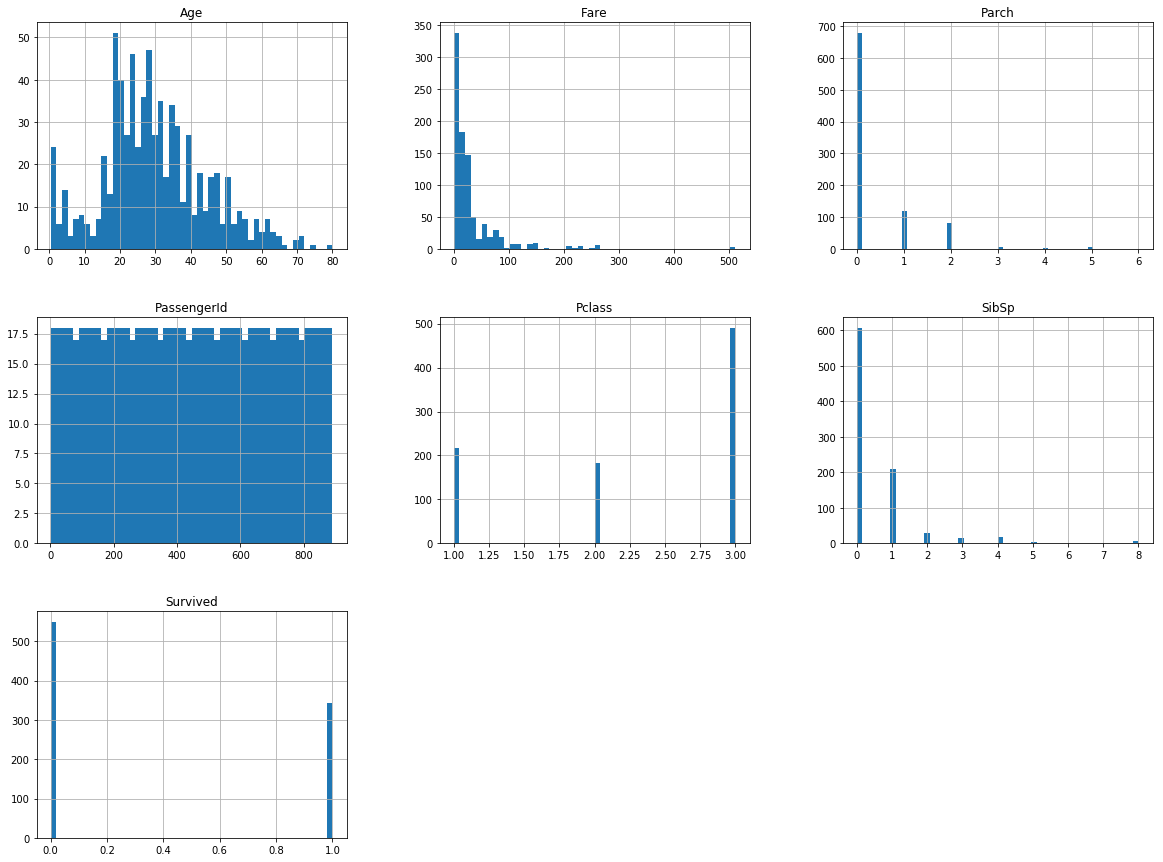

In [193]:
data.hist(bins=50,figsize=(20,15))

In [382]:
import xgboost as xgb

In [384]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(data_train,label_train)
print(xgb_classifier.score(data_test,label_test))

0.8324022346368715


In [385]:
param_grid={'max_depth': [2,4,6],
'n_estimators': [50,100,200]}
grid_search = GridSearchCV(estimator=xgb_classifier,cv=5,param_grid=param_grid,n_jobs=-1)
grid_search.fit(data_train, label_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 200], 'max_depth': [2, 4, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [387]:
grid_search.best_params_

{'max_depth': 2, 'n_estimators': 200}